<a href="https://colab.research.google.com/github/Jinseon-Kim/AI-Project/blob/main/NLP_of_customer_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##화장품 리뷰 감성 분석, 예측하기 

###1. 데이터 소개

이번 프로젝트에서 샤용하는 데이터는 어뮤즈라는 색조 화장 브랜드의 "어뮤즈 듀 젤리 비건 쿠션" 이라는 제품의 네이버 쇼핑 리뷰이다.<br> 
selenium을 활용해 총 3,458개의 리뷰와 평점 정보를 스크래핑하였다.


###2. 데이터에 대한 이해와 전처리

In [1]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 641 kB/s 
     |████████████████████████████████| 453 kB 84.6 MB/s 


In [2]:
# Colab에 Mecab(형태소 분석기) 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 1.42 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-10-05 07:07:55--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::6b17:d1f5, 2406:da00:ff00::22e9:9f55, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bb

In [3]:
import re
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot
import urllib.request
from collections import Counter
from wordcloud import WordCloud

from konlpy.tag import Okt
from konlpy.tag import Hannanum 
from konlpy.tag import Kkma
from konlpy.tag import Komoran
from konlpy.tag import Mecab

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
matplotlib.rcParams['axes.unicode_minus'] = False

Selecting previously unselected package fonts-nanum.
(Reading database ... 159740 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
NanumBarunGothic


####1) 데이터 로드

In [5]:
from google.colab import files
uploaded = files.upload()

Saving shopping_review.csv to shopping_review.csv


In [115]:
data = pd.read_csv('shopping_review.csv', usecols=['review', 'star'])
data['star'] = data['star'].str.replace("평점", "")
data.reset_index(inplace=True, drop=True)
data.head(10)

,review,star
0,가벼운 화장을 하고싶어서 톤업크림을 알아보다가\n덜답답한 쿠션이 있나 찾게됨\n커버...,5
1,"V 21호 정도의 수부지 피부\nV 주근깨 있음, 여드름이나 큰 모공은 없는 편\n...",4
2,"제 피부 타입은 수부지이고, 약간의 민감성이에요\n작년에 트러블로 엄청 고생했어서 ...",5
3,"뗑이돌이나 정샘* 에센셜쿠션 같이 세미매트하거나 촉촉파데를 즐겨쓰는데, 커버력 없이...",5
4,받았을때 비건쿠션답게 재활용 편한것들로 왔어요. 컴팩트하고 딱 기본에만 충실한 느낌...,5
5,전 원래 피부화장 진짜 진짜 얇게 하는 걸 좋아해서 쿠션 쓰면 퍼프 반을 넘게 묻혀...,5
6,파우치는약간양파망같단생각이ㅋ\n케이스는두껍고크고무거운편이에요\n첫느낌은뭐야발리는거맞...,5
7,평소에 톤보정되는 선크림만 썼었는데 너무 건조해서 알아보다가 구매했습니다.\n저는 ...,5
8,전 분명히 하나 시켰는데 4개가 왔어요..ㅋㅋㅋ 진짜 선물박스야 뭐야❤️ 심지어 사...,5
9,평소에 쿠션을 잘사용안하고있다가\n\n비건제품으로는 어뮤즈가 인기가 많아서 궁금해서...,5


In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  3287 non-null   object
 1   star    3287 non-null   object
dtypes: object(2)
memory usage: 51.5+ KB


In [117]:
data['star']=data['star'].astype(int)

In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  3287 non-null   object
 1   star    3287 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 51.5+ KB


In [119]:
print('전체 리뷰 개수 :', data.shape[0])

전체 리뷰 개수 : 3287


위의 그래프를 볼 때, 긍/부정으로 분류하기 애매한 3점에 해당하는 리뷰들은 제외된 것을 알 수 있다.

####2) 데이터 전처리

#####a. 중복되는 행 제거

In [120]:
data.head()

,review,star
0,가벼운 화장을 하고싶어서 톤업크림을 알아보다가\n덜답답한 쿠션이 있나 찾게됨\n커버...,5
1,"V 21호 정도의 수부지 피부\nV 주근깨 있음, 여드름이나 큰 모공은 없는 편\n...",4
2,"제 피부 타입은 수부지이고, 약간의 민감성이에요\n작년에 트러블로 엄청 고생했어서 ...",5
3,"뗑이돌이나 정샘* 에센셜쿠션 같이 세미매트하거나 촉촉파데를 즐겨쓰는데, 커버력 없이...",5
4,받았을때 비건쿠션답게 재활용 편한것들로 왔어요. 컴팩트하고 딱 기본에만 충실한 느낌...,5


In [121]:
data.duplicated().sum()

1289

In [122]:
data = data.iloc[:2000]
data.duplicated().sum()

3

원인을 모르겠지만 selenium이 최대 2000개까지만 가능하고 그 이상의 index는 중복된 데이터임을 확인 <br>
전체 데이터 중 2000개만 사용

In [123]:
data.drop_duplicates(['review'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [124]:
data.duplicated().sum()

0

#####b. 결측치 제거

In [125]:
data.isnull().sum()

review    0
star      0
dtype: int64

In [126]:
df = data.copy()

####3)텍스트 전처리

#####a.정규표현식

In [127]:
df.head()

,review,star
0,가벼운 화장을 하고싶어서 톤업크림을 알아보다가\n덜답답한 쿠션이 있나 찾게됨\n커버...,5
1,"V 21호 정도의 수부지 피부\nV 주근깨 있음, 여드름이나 큰 모공은 없는 편\n...",4
2,"제 피부 타입은 수부지이고, 약간의 민감성이에요\n작년에 트러블로 엄청 고생했어서 ...",5
3,"뗑이돌이나 정샘* 에센셜쿠션 같이 세미매트하거나 촉촉파데를 즐겨쓰는데, 커버력 없이...",5
4,받았을때 비건쿠션답게 재활용 편한것들로 왔어요. 컴팩트하고 딱 기본에만 충실한 느낌...,5


In [128]:
#한글과 공백을 제외하고 모두 제거하기
df['review'] = df['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['review'].replace("", np.nan, inplace=True) #결측치 nan으로 표기하기
df.isnull().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


review    0
star      0
dtype: int64

In [129]:
df.head(5)

,review,star
0,가벼운 화장을 하고싶어서 톤업크림을 알아보다가덜답답한 쿠션이 있나 찾게됨커버력이 낮...,5
1,호 정도의 수부지 피부 주근깨 있음 여드름이나 큰 모공은 없는 편 커버력에는 크게...,4
2,제 피부 타입은 수부지이고 약간의 민감성이에요작년에 트러블로 엄청 고생했어서 트러블...,5
3,뗑이돌이나 정샘 에센셜쿠션 같이 세미매트하거나 촉촉파데를 즐겨쓰는데 커버력 없이 얇...,5
4,받았을때 비건쿠션답게 재활용 편한것들로 왔어요 컴팩트하고 딱 기본에만 충실한 느낌베...,5


#####b. 토큰화

텍스트를 의미 있는 최소 단위인 토큰으로 쪼개는 과정을 수행한다.<br>
한국어의 경우 의미를 가지는 최소 단위는 형태소이므로 형태소 단위의 토큰화를 진행한다.<br>
Konlpy에는 품사 태깅을 위해 다음과 같은 옵션이 존재하며 어떤 클래스를 이용하는 것이 적절한지 비교해보았다.

In [131]:
mecab = Mecab()
hannanum = Hannanum()
komoran = Komoran()
kkma = Kkma()
okt = Okt()

print('mecab :', mecab.morphs('피부가 예민한데 잘맞는거같아요피부가 아주 편해요')) #morphs : 형태소 추출

print('hannanum :', hannanum.morphs('피부가 예민한데 잘맞는거같아요피부가 아주 편해요'))

print('komoran :', komoran.morphs('피부가 예민한데 잘맞는거같아요피부가 아주 편해요'))

print('kkma :', kkma.morphs('피부가 예민한데 잘맞는거같아요피부가 아주 편해요'))

print('okt :', okt.morphs("피부가 예민한데 잘맞는거같아요피부가 아주 편해요"))

mecab : ['피부', '가', '예민', '한데', '잘', '맞', '는', '거', '같', '아요', '피부', '가', '아주', '편해요']
hannanum : ['피부', '가', '예민한데', '잘맞는거같아요피부', '가', '아주', '편하', '어요']
komoran : ['피부', '가', '예민', '하', 'ㄴ데', '잘', '맞', '는', '거', '같', '아요', '피부', '가', '아주', '편하', '아요']
kkma : ['피부', '가', '예민', '하', 'ㄴ데', '잘', '맞', '는', '거', '같', '아요', '피부', '가', '아주', '편하', '어요']
okt : ['피부', '가', '예민한데', '잘맞는거', '같아요', '피부', '가', '아주', '편해요']


스크래핑한 화장품 리뷰의 경우 띄어쓰기가 잘 되어 있지 않는 경우가 대부분이었는데 5개의 형태소 분석기의 결과를 보면 <br>
임의의 문장에 대해 테스트한 토큰화 결과 hannanum은 띄어쓰기가 없을 경우 적합하지 않음을 확인할 수 있다.

In [132]:
print('형태소 :', okt.morphs("흡수력은 좋지만 커버력이 나빠요"))
print('명사 :', okt.nouns('흡수력은 좋지만 커버력이 나빠요'))

형태소 : ['흡수', '력', '은', '좋지만', '커버', '력', '이', '나빠요']
명사 : ['흡수', '커버']


nouns 메소드의 경우 하나의 리뷰에 각 속성에 대한 상반된 평가를 담지 못함을 확인할 수 있다.

In [133]:
print(okt.morphs("성분도 착하고 촉촉하다고 해서 구입했습니닿ㅎ"))
print(okt.morphs("성분도 착하고 촉촉하다고 해서 구입했습니닿ㅎ", norm=True))

['성분', '도', '착하고', '촉촉하다고', '해서', '구입', '했', '습', '니', '닿', 'ㅎ']
['성분', '도', '착하고', '촉촉하다고', '해서', '구입', '했습니다', 'ㅎ']


morph의 파라미터로 norm은 문장을 정규화하고, stem은 각 단어에서 어간을 추출한다.

In [134]:
print('mecab :', mecab.morphs('커버력이 약하지만 쿨링감도 좋고 촉촉해서 수부지에게 만족스러워요'))

print('hannanum :', hannanum.morphs('커버력이 약하지만 쿨링감도 좋고 촉촉해서 수부지에게 만족스러워요'))

print('komoran :', komoran.morphs('커버력이 약하지만 쿨링감도 좋고 촉촉해서 수부지에게 만족스러워요'))

print('kkma :', kkma.morphs('커버력이 약하지만 쿨링감도 좋고 촉촉해서 수부지에게 만족스러워요'))

print('okt :', okt.morphs("커버력이 약하지만 쿨링감도 좋고 촉촉해서 수부지에게 만족스러워요"))

mecab : ['커', '버력', '이', '약하', '지만', '쿨링', '감', '도', '좋', '고', '촉촉', '해서', '수', '부지', '에게', '만족', '스러워', '요']
hannanum : ['커버력', '이', '약하', '지', '말', 'ㄴ', '쿨링감', '도', '좋', '고', '촉촉하', '어서', '수부지에', '이', '게', '만족', '스럽', '어요']
komoran : ['커버', '력', '이', '약하', '지만', '쿠', 'ㄹ', '링', '감', '도', '좋', '고', '촉촉', '하', '아서', '수', '부지', '에게', '만족', '스럽', '어요']
kkma : ['커버', '력', '이', '약하', '지만', '쿨링', '감도', '좋', '고', '촉촉', '하', '어서', '수', '부지', '에게', '만족', '스럽', '어요']
okt : ['커버', '력', '이', '약하지만', '쿨링', '감도', '좋고', '촉촉해서', '수', '부지', '에게', '만족스러워요']


화장품에 대한 특징을 설명할 때 등장하는 '커버력', '쿨링감'과 같은 단어에 대해서는 형태소 분석기로 파악하기 어려움

In [135]:
# df['tokenized'] = df['review'].apply(okt.morphs)
df['tokenized'] = df.apply(lambda x: okt.morphs(x['review'], norm=True), axis=1)

In [136]:
df.head()

,review,star,tokenized
0,가벼운 화장을 하고싶어서 톤업크림을 알아보다가덜답답한 쿠션이 있나 찾게됨커버력이 낮...,5,"[가벼운, 화장, 을, 하고싶어서, 톤업, 크림, 을, 알아보다가, 덜, 답답한, ..."
1,호 정도의 수부지 피부 주근깨 있음 여드름이나 큰 모공은 없는 편 커버력에는 크게...,4,"[호, 정도, 의, 수, 부지, 피부, 주근깨, 있음, 여드름, 이나, 큰, 모공,..."
2,제 피부 타입은 수부지이고 약간의 민감성이에요작년에 트러블로 엄청 고생했어서 트러블...,5,"[제, 피부, 타입, 은, 수, 부지, 이고, 약간, 의, 민감, 성, 이에요, 작..."
3,뗑이돌이나 정샘 에센셜쿠션 같이 세미매트하거나 촉촉파데를 즐겨쓰는데 커버력 없이 얇...,5,"[뗑이돌, 이나, 정샘, 에센셜, 쿠션, 같이, 세미, 매트, 하, 거나, 촉촉, ..."
4,받았을때 비건쿠션답게 재활용 편한것들로 왔어요 컴팩트하고 딱 기본에만 충실한 느낌베...,5,"[받았을, 때, 비건, 쿠션, 답, 게, 재활용, 편한것, 들로, 왔어요, 컴팩트,..."


#####c. 빈도수 확인하기

In [137]:
df['star'].value_counts()

5    1483
4     359
3     123
2      19
1      13
Name: star, dtype: int64

In [138]:
positive_words= np.hstack(df[df.star.between(4,5)]['tokenized'].values)
negative_words= np.hstack(df[df.star<=3]['tokenized'].values)

negative_words_count = Counter(negative_words)
negative_words_count.most_common(20)

[('이', 165),
 ('은', 111),
 ('력', 99),
 ('커버', 85),
 ('에', 78),
 ('가', 70),
 ('피부', 65),
 ('도', 60),
 ('는', 54),
 ('느낌', 46),
 ('잘', 44),
 ('안', 42),
 ('쿠션', 37),
 ('같아요', 37),
 ('요', 36),
 ('것', 34),
 ('저', 32),
 ('들', 29),
 ('때', 29),
 ('사용', 28)]

In [139]:
positive_words_count = Counter(positive_words)
positive_words_count.most_common(20)

[('이', 1916),
 ('에', 1296),
 ('커버', 1184),
 ('피부', 1153),
 ('력', 1105),
 ('은', 991),
 ('도', 982),
 ('쿠션', 934),
 ('가', 791),
 ('너무', 661),
 ('는', 589),
 ('잘', 506),
 ('좋아요', 471),
 ('을', 470),
 ('제품', 435),
 ('사용', 381),
 ('으로', 380),
 ('것', 380),
 ('안', 375),
 ('구매', 357)]

리뷰를 기준으로 어떤 단어들이 긍정리뷰와 부정리뷰에 등장하는지에 대해 빈도수 계산을 한 결과,<br>
조사, 접속사와 같은 불용어로 인해 키워드 파악이 어려움을 확인하였다. 또한 제품, 쿠션, 피부, 사용과 같이 속성과 감성에 대한 단어가 아닌 화장품 리뷰에서 빈번히 등장하는 단어도 불용어처리를 해야함을 알게 되었다.


#####c.불용어 지정

In [140]:
stopwords = ['은', '는', '이', '가', '에', '도', '는', '것', '저', '들', '도', '너무', '아주', '완전', '정말', '진짜', '인데', '을', '를', '게', '듯', '과', '와','때', '한', '으로', '거', '고' ,'요','제', '거의', '로', '만', '제', '다', '요', '같아요', '해서', '했는데', '하고','네','이라', '많이', '잘', '안', '분', '보다','더', '다른', '에는','정도', '해서' '제품', '쿠션', '사용', '시간', '피부', '구매', '느낌', '화장', '생각', '력']

In [141]:
df['tokenized'] = df['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

불용어 처리 후 상위 단어

In [142]:
positive_words= np.hstack(df[df.star.between(4,5)]['tokenized'].values)
negative_words= np.hstack(df[df.star<=3]['tokenized'].values)

negative_words_count = Counter(negative_words)
negative_list = negative_words_count.most_common(100)
negative_list[:20]

[('커버', 85),
 ('밀착', 22),
 ('건성', 21),
 ('좀', 20),
 ('그냥', 19),
 ('별로', 19),
 ('ㅠㅠ', 19),
 ('마스크', 17),
 ('ㅠ', 17),
 ('지속', 15),
 ('제품', 15),
 ('없고', 14),
 ('바를', 13),
 ('조금', 13),
 ('없는', 12),
 ('나', 12),
 ('바르고', 12),
 ('퍼프', 12),
 ('못', 12),
 ('광', 12)]

In [143]:
positive_words_count = Counter(positive_words)
positive_list = positive_words_count.most_common(100)
positive_list[:20]

[('커버', 1184),
 ('좋아요', 471),
 ('제품', 435),
 ('마스크', 335),
 ('비건', 324),
 ('표현', 303),
 ('밀착', 268),
 ('촉촉하고', 250),
 ('톤', 231),
 ('ㅎㅎ', 209),
 ('좋은', 196),
 ('좀', 190),
 ('입니다', 184),
 ('광', 176),
 ('틴트', 174),
 ('얼굴', 169),
 ('써', 164),
 ('어뮤즈', 162),
 ('딱', 158),
 ('케이스', 158)]

####4) 감성분석

#####a. 결과해석

긍정과 부정리뷰 상위 키워드를 통해 알 수 있는 점 <br>
긍정리뷰 : 고객들은 밀착력과 촉촉함에서 만족감을 느꼈으며 마스크라는 키워드가 등장한 것으로 보아 화장 후 마스크 착용시에도 괜찮았다는 의미로 추측된다. <br>
부정리뷰 : 고객들은 제품의 커버력, 밀착력에 부정적인 반응을 보임을 알 수 있으며 건성의 피부타입의 경우 만족도가 낮았던 것을 파악했다. <br>
제품 마케팅에서 언급했던 촉촉,밀착,묻어남 없음을 고객들이 경험했음을 확인할 수 있다. <Br>
하지만 두 리뷰를 비교해보면 커버력이 가장 많이 언급된 단어임을 알 수 있는데 커버력이라는 제품의 속성에 대해서는 만족도의 편차가 크다는 것을 알 수 있다.  

#####b. word cloud

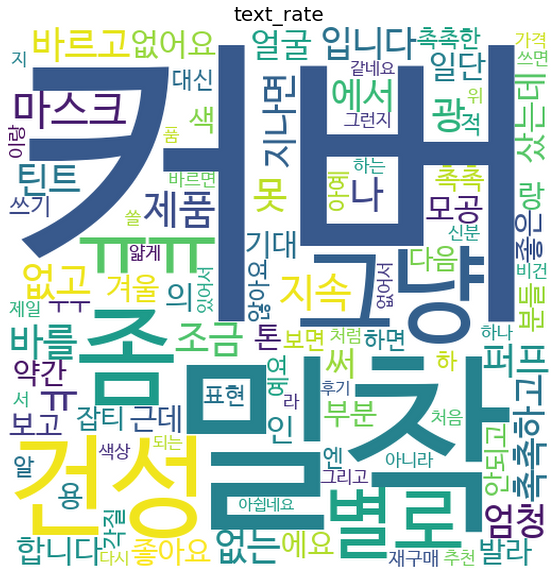

In [144]:
#negative word cloud image
wc = WordCloud(font_path = font_path,
                    background_color = 'white',
                    width=512, height=512,
                    max_font_size=500,
                    max_words=1000)
wc.generate_from_frequencies(dict(negative_list))
plt.figure(figsize=(10,10)) #이미지 사이즈 지정
plt.title('text_rate', fontsize=20)
plt.imshow(wc, interpolation='lanczos') #이미지의 부드럽기 정도
plt.axis('off') #x y 축 숫자 제거
plt.show()  # 워드클라우드 이미지 확인

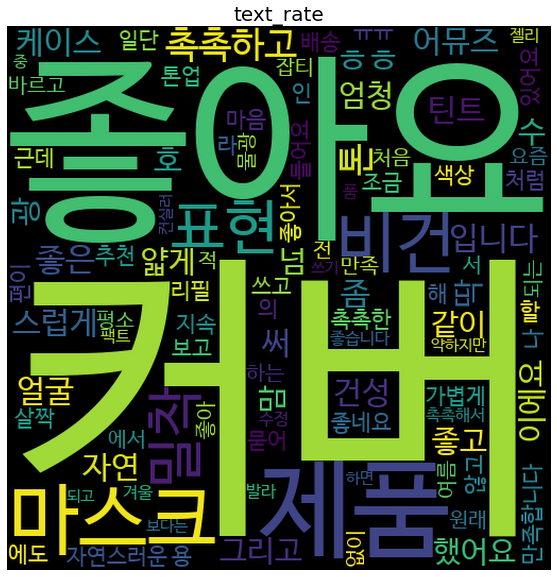

In [145]:
#positive word cloud image
wc = WordCloud(font_path = font_path,
                    background_color = 'black',
                    width=512, height=512,
                    max_font_size=500,
                    max_words=1000)
wc.generate_from_frequencies(dict(positive_list))
plt.figure(figsize=(10,10)) #이미지 사이즈 지정
plt.title('text_rate', fontsize=20)
plt.imshow(wc, interpolation='lanczos') #이미지의 부드럽기 정도
plt.axis('off') #x y 축 숫자 제거
plt.show()  # 워드클라우드 이미지 확인

In [146]:
x = df[df['star']<=3]
x[x['review'].str.contains('커버')]

,review,star,tokenized
23,정말 솔직히 작성하겠습니다 진짜 시중의 쿠션 진짜 많이 써봤는데 이렇게 안바른느낌의...,2,"[솔직히, 작성, 하겠습니다, 시중, 의, 써, 봤는데, 이렇게, 바른, 의, 처음..."
44,커버력은 원치 않았던 터라 상관이 없는데 밀착력이 정말 안좋아요 마치 오일바르고 베...,3,"[커버, 원, 치, 않았던, 터, 라, 상관, 없는데, 밀착, 안좋아요, 마치, 오..."
48,피부가 건성이라 겨울외에 환절에도 촉촉한 쿠션을 찾고 있었어요 일단 패키지가 너무 ...,3,"[건성, 겨울, 외, 환절, 에도, 촉촉한, 찾고, 있었어요, 일단, 패키지, 예쁘..."
77,너무 많은 기대를 했나봐요 기존에 쓰던 샤 쿠션과 사용감이 비슷하다고 해서 더욱이 ...,3,"[많은, 기대, 했나, 봐요, 기존, 쓰던, 샤, 사, 용감, 비슷하다고, 더욱이,..."
155,제 피부랑은 맞지 않은 거 같네요 기대하고 샀는데 아쉬워요 커버력 약한건 감안하고 ...,2,"[랑은, 맞지, 않은, 같네요, 기대하고, 샀는데, 아쉬워요, 커버, 약한건, 감안..."
...,...,...,...
1925,밀착력도 좋고 산뜻하고 좋은데 커버가 잘 안돼요,3,"[밀착, 좋고, 산뜻하고, 좋은데, 커버, 돼요]"
1938,확실히 광은 나는데 커버력이 많이 아쉬워요ㅠㅜ,3,"[확실히, 광, 나는데, 커버, 아쉬워요, ㅠㅜ]"
1940,촉촉하고 화장 잘되요 커버력은 약하지만 좋아요,3,"[촉촉하고, 되요, 커버, 약하지만, 좋아요]"
1966,저는 잘 안맞았어요커버는 잘 되나 조금 뜨네요,3,"[맞았어요, 커버, 되나, 조금, 뜨네요]"


####5)감성예측

평점 데이터를 바탕으로 label을 만들어 지도 학습 기반의 긍정/부정 예측을 진행했다.

#####a. 레이블 만들기

In [147]:
df['label'] = np.select([df.star > 3], [1])
df.sample(5)

,review,star,tokenized,label
1312,오늘 와서 사용전이예요 써보고 괜찮으면 재구매할려구요 사은품 잘쓸께요,3,"[오늘, 와서, 전이, 예요, 써, 보고, 괜찮으면, 재구매, 할려, 구, 사은, ...",0
0,가벼운 화장을 하고싶어서 톤업크림을 알아보다가덜답답한 쿠션이 있나 찾게됨커버력이 낮...,5,"[가벼운, 하고싶어서, 톤업, 크림, 알아보다가, 덜, 답답한, 있나, 찾게, 됨,...",1
1845,톤업정도 하려고 커버 안 되는거 알고 사서 괜찮아요,5,"[톤업, 하려고, 커버, 되는거, 알, 사서, 괜찮아요]",1
361,존 지성피부인데 볼이 너무 건조해져서 촉촉한 쿠션으로 바꿔봤습니다 쫀쫀하게 얇고 밀...,5,"[존, 지, 성, 볼, 건조해져서, 촉촉한, 바꿔, 봤습니다, 쫀쫀하, 얇고, 밀착...",1
1322,커버력은 약한거 알고샀는데 생각보다 괜찮네요뭣보다 바른직후 윤광이 미쳤어요피부 진짜...,5,"[커버, 약한거, 알, 샀는데, 괜찮네요, 뭣, 바른, 직후, 윤광, 미쳤어요, 좋...",1


In [148]:
df['label'].value_counts()

1    1842
0     155
Name: label, dtype: int64

In [149]:
print(f'긍정 리뷰 비율 = {round(df["label"].value_counts()[1]/len(df) * 100,3)}%')
print(f'부정 리뷰 비율 = {round(df["label"].value_counts()[0]/len(df) * 100,3)}%')

긍정 리뷰 비율 = 92.238%
부정 리뷰 비율 = 7.762%


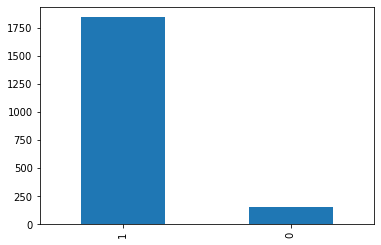

In [150]:
df['label'].value_counts().plot(kind='bar')

positive와 negative class가 불균형한 상태임을 알 수 있다. <br>
클래스의 균형을 맞추기 위해 trainig set의 negative class에 더 큰 loss 값을 갖도록 만든다.

#####b. train-test 데이터셋 분리

In [151]:
train, test = train_test_split(df, test_size=0.25, random_state = 42, stratify=df['label'])
print('훈련용 리뷰 개수 :', len(train))
print('테스트용 리뷰 개수 :', len(test))

훈련용 리뷰 개수 : 1497
테스트용 리뷰 개수 : 500


In [152]:
X_train = train['tokenized']
y_train = train['label']
X_test = test['tokenized']
y_test = test['label']

In [153]:
X_train

1777                         [좋은데, 왜, 이리, 큰지, 틴트, 마음, 듭니]
1065    [얇게, 발리, 물광, 표현, 되는, 밤, 팩트, 원하는데, 기대, 만큼, 일지, ...
1708    [주, 째, 중, 촉촉해요, 커, 바, 약하지만, 마스크, 쓰니까, 크게, 신경안,...
1374    [옅은, 색조화, 장이, 나, 안경, 낄, 조금, 화사, 해보이고, 싶을, 하기, ...
1164    [배송, 꼼꼼하고, 빠르고, 리뷰, 찾아본대로, 착, 붙이, 라, 만족합니다, 촉촉해요]
                              ...                        
1608           [번, 들거, 림, 없이, 밀착, 돼서, 톤, 깔끔하게, 맞추기, 좋습니다]
244     [보통, 파데를, 쓰고, 박이상, 외출, 시, 하려고, 했었는데, 실패했었어요, 악...
1068          [자연스러운, 표현, 좋아해요, 그런, 면, 있어서, 아뮤즈, 최고, 입니다]
669     [그, 전, 하던, 단종, 되고, 유목민, 살다가, 특가, 알, 되었네요, 근데, ...
1350          [커버, 없지만, 여름, 가볍게, 표현, 하기는, 괜찮아요, 잘쓰고, 있어요]
Name: tokenized, Length: 1497, dtype: object

#####c. 정수인코딩

컴퓨터가 텍스트를 처리할 수 있도록 등장 횟수를 기반으로 숫자로 처리하는 정수 인코딩을 수행한다. 

In [154]:
#keras의 토크나이저 이용
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)  #빈도수를 기준으로 단어 집합 생성, 빈도수가 높은 순으로 낮은 정수 인덱스 부여

In [155]:
print(tokenizer.word_index)

{'커버': 1, '좋아요': 2, '제품': 3, '마스크': 4, '비건': 5, '표현': 6, '밀착': 7, '촉촉하고': 8, '톤': 9, '좀': 10, '좋은': 11, 'ㅎㅎ': 12, '입니다': 13, '틴트': 14, '써': 15, '케이스': 16, '얼굴': 17, '건성': 18, '광': 19, '호': 20, '스럽게': 21, '어뮤즈': 22, '딱': 23, '맘': 24, '엄청': 25, '자연': 26, '얇게': 27, '추천': 28, '좋고': 29, '라': 30, '이에요': 31, '넘': 32, '같이': 33, '했어요': 34, '자연스러운': 35, '수': 36, '지속': 37, '묻어': 38, '그리고': 39, '톤업': 40, '할': 41, '가볍게': 42, '의': 43, '조금': 44, 'ㅠㅠ': 45, '않고': 46, '촉촉한': 47, '일단': 48, '만족합니다': 49, '보고': 50, '근데': 51, '들어요': 52, '있어요': 53, '편이': 54, '쓰고': 55, '하는': 56, '인': 57, '처럼': 58, '해': 59, '마음': 60, '색상': 61, '좋아서': 62, '바르고': 63, '좋네요': 64, '적': 65, '나': 66, '용': 67, '에도': 68, '에서': 69, '전': 70, '배송': 71, '원래': 72, '만족': 73, '리필': 74, '되는': 75, '살짝': 76, '없고': 77, '없이': 78, '좋습니다': 79, '잡티': 80, '합니다': 81, '요즘': 82, '여름': 83, '물광': 84, '평소': 85, '수정': 86, '좋아': 87, '촉촉해서': 88, '색': 89, '약하지만': 90, '재구매': 91, '없어요': 92, '바를': 93, '그냥': 94, '처음': 95, '팩트': 96, '없는': 97, '겨울': 98, '서': 99, '별로':

In [156]:
#등장 횟수가 1회인 단어들은 자연어 처리에서 배제
threshold = 2
total_cnt = len(tokenizer.word_index) #전체 단어수
rare_cnt = 0 
total_freq = 0
rare_freq = 0

#단어와 빈도수의 쌍을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    #단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
      rare_cnt = rare_cnt + 1
      rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 6676
등장 빈도가 1번 이하인 희귀 단어의 수: 3786
단어 집합에서 희귀 단어의 비율: 56.7106051527861
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 10.46665929448192


In [157]:
#전체 등장 빈도에서 희귀 단어 등장 빈도 비율이 10%에 해당하기 때문에 제거하지 않고 진행
#0번 패딩 토큰을 고려하여 +1

vocab_size = total_cnt + 1
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train) #정수 인코딩 진행 
X_test = tokenizer.texts_to_sequences(X_test)

In [158]:
#전체 등장 빈도에서 희귀 단어 등장 빈도 비율이 10%에 해당하기 때문에 제거하지 않고 진행
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2

# vocab_size = total_cnt - rare_cnt + 2
# tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
# tokenizer.fit_on_texts(X_train)
# X_train = tokenizer.texts_to_sequences(X_train) #정수 인코딩 진행 
# X_test = tokenizer.texts_to_sequences(X_test)

In [159]:
X_train[:5]

[[258, 455, 2891, 2892, 14, 60, 314],
 [27, 178, 84, 6, 75, 1534, 96, 2893, 194, 488, 2894, 59, 1974, 81],
 [690, 1066, 115, 195, 839, 1067, 90, 4, 945, 354, 760, 1535, 88, 204, 1975],
 [1536, 2895, 1537, 66, 2896, 2897, 44, 634, 1068, 1069, 185, 2],
 [71, 1976, 433, 240, 2898, 275, 1538, 30, 49, 195]]

#####d. 패딩

서로 다른 길이의 샘플들의 길이를 동일하게 맞춰준다.

리뷰의 최대 길이 : 178
리뷰의 평균 길이 : 24.162992651970608


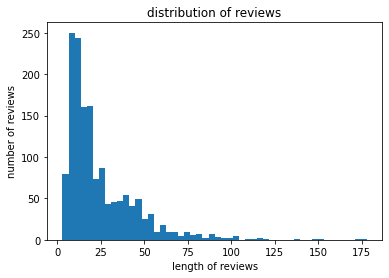

In [160]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of reviews')
plt.ylabel('number of reviews')
plt.title('distribution of reviews')
plt.show()

In [161]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [162]:
max_len = 100
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 99.06479625918504


전체 train 리뷰의 99%가 100이하의 길이를 가지므로 train 리뷰를 100으로 패딩한다.

In [163]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

#####e. 리뷰 감성 분류하기

- label over_sampling

In [164]:
# 필요 함수 정의
def count_and_plot(y): 
    counter = Counter(y)
    for k,v in counter.items():
        print('Class=%d, n=%d (%.3f%%)' % (k, v, v / len(y) * 100))
    pyplot.bar(counter.keys(), counter.values())
    pyplot.show()

Class=1, n=1381 (50.000%)
Class=0, n=1381 (50.000%)


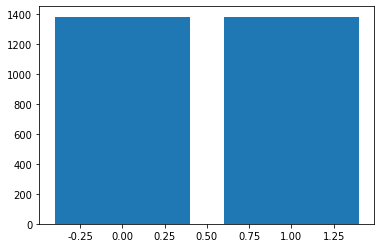

In [165]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=0).fit_resample(X_train, y_train)
count_and_plot(y_resampled)

In [177]:
import keras
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_resampled, y_resampled, epochs=10, callbacks=[es, mc], batch_size=64, validation_split=0.2)


Epoch 1/10
32/35 [==========================>...] - ETA: 0s - loss: 0.6542 - acc: 0.6206
Epoch 1: val_acc improved from -inf to 0.00000, saving model to best_model.h5
35/35 [==============================] - 4s 23ms/step - loss: 0.6524 - acc: 0.6193 - val_loss: 0.9627 - val_acc: 0.0000e+00
Epoch 2/10
33/35 [===========================>..] - ETA: 0s - loss: 0.5409 - acc: 0.6851
Epoch 2: val_acc improved from 0.00000 to 0.16456, saving model to best_model.h5
35/35 [==============================] - 0s 9ms/step - loss: 0.5374 - acc: 0.6895 - val_loss: 1.1037 - val_acc: 0.1646
Epoch 3/10
32/35 [==========================>...] - ETA: 0s - loss: 0.4088 - acc: 0.8398
Epoch 3: val_acc improved from 0.16456 to 0.43400, saving model to best_model.h5
35/35 [==============================] - 0s 9ms/step - loss: 0.4055 - acc: 0.8438 - val_loss: 0.9565 - val_acc: 0.4340
Epoch 4/10
33/35 [===========================>..] - ETA: 0s - loss: 0.2986 - acc: 0.9006
Epoch 4: val_acc improved from 0.43400 to 

In [178]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

16/16 [==============================] - 0s 3ms/step - loss: 0.3837 - acc: 0.8060

 테스트 정확도: 0.8060


In [179]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, norm=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [180]:
sentiment_predict("밀착력이 좋아요")

97.42% 확률로 긍정 리뷰입니다.



In [187]:
sentiment_predict("밀착력이 안좋아요")

53.97% 확률로 부정 리뷰입니다.



In [183]:
sentiment_predict("아직은 잘 모르겠어요ㅠ")

81.13% 확률로 부정 리뷰입니다.



In [184]:
sentiment_predict("커버력은 약하지만 밀착력은 좋아요")

99.43% 확률로 긍정 리뷰입니다.



In [186]:
sentiment_predict("커버력은 별로네요,디자인과 수분력은 좋아요")

85.70% 확률로 긍정 리뷰입니다.



In [188]:
sentiment_predict("3통째 사용합니다 가볍고 촉촉합니다")

62.44% 확률로 부정 리뷰입니다.

